In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
cutde_slash = np.load("../tests/okada_western_north_america_actual.npz")["arr_0"]
cutde_v = np.load("../tests/okada_western_north_america_actual_v.npz")["arr_0"]

# expected = np.load("../tests/okada_japan_expected.npz")["arr_0"]
# actual = np.load("../tests/okada_japan_actual.npz")["arr_0"]

In [4]:
np.isnan(cutde_slash).mean(), np.isnan(cutde_v).mean()

(np.float64(0.0), np.float64(0.0))

/home/mares/repos/celeri/.pixi/envs/default/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


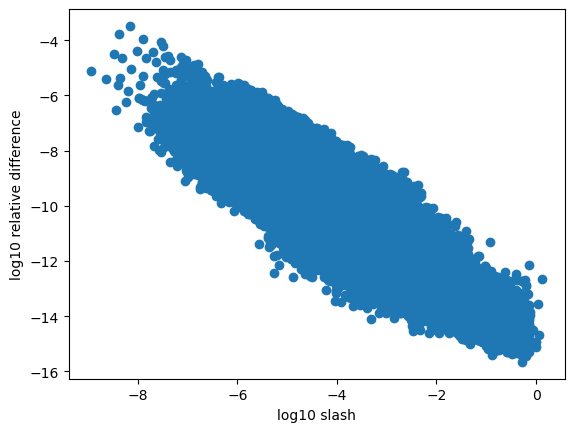

/home/mares/repos/celeri/.pixi/envs/default/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


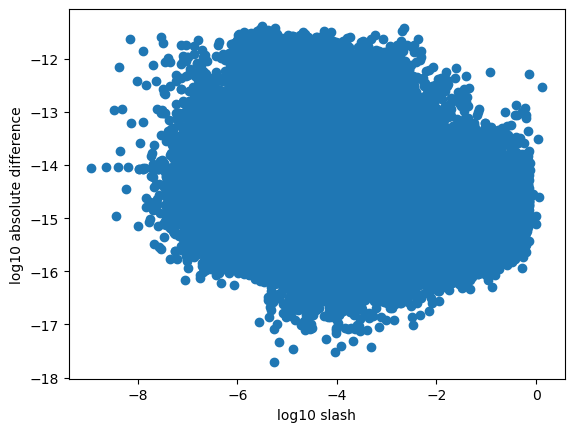

In [6]:
# Japan
n_segments = 481
n_stations = 954

# Western North America
n_segments = 837
n_stations = 1686

reshaped_cutde_v = cutde_v.reshape(n_stations, 3, n_segments, 3)
reshaped_cutde_slash = cutde_slash.reshape(n_stations, 3, n_segments, 3)
# (station, displacement, segment, slip_type)

displacement = ["east", "north", "up"]
slip_type = ["strike", "dip", "tensile"]
algorithm = ["/", "v", "difference"]

combined = np.stack([reshaped_cutde_slash, reshaped_cutde_v, reshaped_cutde_slash - reshaped_cutde_v])

results = xr.DataArray(
    combined,
    dims=["algorithm", "station", "displacement", "segment", "slip_type"],
    coords={
        "station": np.arange(n_stations),
        "displacement": displacement,
        "segment": np.arange(n_segments),
        "slip_type": slip_type,
        "algorithm": algorithm,
    },
)

results.sel(
    algorithm="/", station=1, displacement="north", segment=29, slip_type="tensile"
)
# results.sel(algorithm="difference", slip_type="tensile", displacement="up").values *= 0

# Take squared-norms along the displacement and slip_type dimensions
norms = np.sqrt(np.square(results).sum(dim=["displacement", "slip_type"]))
norms

# # Set the glitched value to 0 by hand
# glitched_value = norms.values[2,10,245]
# norms.values[2,10,245] = 0

# If okada is zero, then cutde is also zero. Thus we only need to look at values where
# okada is nonzero, and this lets us take logs.
assert ((norms.sel(algorithm="/") == 0) & (norms.sel(algorithm="v") != 0)).sum().item() == 0

# Logarithmic scatter plot of the norms, x-axis is algorithm="okada", y-axis is algorithm="difference"
plt.scatter(np.log10(norms.sel(algorithm="/")), np.log10(norms.sel(algorithm="difference")) - np.log10(norms.sel(algorithm="/")))
plt.xlabel("log10 slash")
plt.ylabel("log10 relative difference")
plt.show()

# Logarithmic scatter plot of the norms, x-axis is algorithm="okada", y-axis is algorithm="difference"
plt.scatter(np.log10(norms.sel(algorithm="/")), np.log10(norms.sel(algorithm="difference")) - 0 * np.log10(norms.sel(algorithm="/")))
plt.xlabel("log10 slash")
plt.ylabel("log10 absolute difference")
plt.show()
# # Reset the glitched value
# norms.values[2,10,245] = glitched_value


In [61]:
(np.log10(norms.sel(algorithm="difference")) - np.log10(norms.sel(algorithm="okada"))).argmax(...)

/home/mares/repos/celeri/.pixi/envs/default/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


{'station': <xarray.DataArray ()> Size: 8B
 array(0),
 'segment': <xarray.DataArray ()> Size: 8B
 array(116)}

In [62]:
(np.log10(norms.sel(algorithm="difference")) - np.log10(norms.sel(algorithm="okada"))).sel(station=0, segment=116)

/home/mares/repos/celeri/.pixi/envs/default/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()> Size: 8B
array(-3.4833368)
Coordinates:
    station  int64 8B 0
    segment  int64 8B 116

In [63]:
results.sel(station=0, segment=116)

<xarray.DataArray (algorithm: 3, displacement: 3, slip_type: 3)> Size: 216B
array([[[ 4.13785382e-09,  0.00000000e+00, -3.87539505e-09],
        [ 1.48919497e-09,  0.00000000e+00, -3.49238907e-09],
        [ 1.75352875e-09,  0.00000000e+00, -1.95104620e-10]],

       [[ 4.13883677e-09,  0.00000000e+00, -3.87540715e-09],
        [ 1.49129154e-09,  0.00000000e+00, -3.49241621e-09],
        [ 1.75352873e-09,  0.00000000e+00, -1.95121289e-10]],

       [[-9.82947659e-13,  0.00000000e+00,  1.21061319e-14],
        [-2.09656564e-12,  0.00000000e+00,  2.71357818e-14],
        [ 1.75640752e-17,  0.00000000e+00,  1.66689579e-14]]])
Coordinates:
    station       int64 8B 0
  * displacement  (displacement) <U5 60B 'east' 'north' 'up'
    segment       int64 8B 116
  * slip_type     (slip_type) <U7 84B 'strike' 'dip' 'tensile'
  * algorithm     (algorithm) <U10 120B 'okada' 'cutde' 'difference'

In [58]:
# Get the indices of the max value
norms.sel(algorithm="difference").argmax(...)

{'station': <xarray.DataArray ()> Size: 8B
 array(1319)
 Coordinates:
     algorithm  <U10 40B 'difference',
 'segment': <xarray.DataArray ()> Size: 8B
 array(131)
 Coordinates:
     algorithm  <U10 40B 'difference'}

In [48]:
(np.log10(norms.sel(algorithm="difference")) - np.log10(norms.sel(algorithm="okada"))).sel(station=0, segment=116)

/home/mares/repos/celeri/.pixi/envs/default/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


<xarray.DataArray ()> Size: 8B
array(-3.4833368)
Coordinates:
    station  int64 8B 0
    segment  int64 8B 116

In [49]:
norms.sel(station=0, segment=116)

<xarray.DataArray (algorithm: 3)> Size: 24B
array([7.04754801e-09, 7.04858902e-09, 2.31580102e-12])
Coordinates:
    station    int64 8B 0
    segment    int64 8B 116
  * algorithm  (algorithm) <U10 120B 'okada' 'cutde' 'difference'

In [6]:
norms.sel(segment=245, station=10)

<xarray.DataArray (algorithm: 3)> Size: 24B
array([7.14203808e-06, 4.81167350e-06, 2.87719346e-06])
Coordinates:
    station    int64 8B 10
    segment    int64 8B 245
  * algorithm  (algorithm) <U10 120B 'okada' 'cutde' 'difference'

In [56]:
results.sel(segment=245, station=10, displacement="up", slip_type="tensile")
results.sel(station=1471, segment=734, algorithm="difference")
results.sel(station=764, segment=365, algorithm="difference", slip_type="dip")
results.sel(station=0, segment=116, algorithm="okada", slip_type="strike", displacement="north")

<xarray.DataArray ()> Size: 8B
array(1.48919497e-09)
Coordinates:
    station       int64 8B 0
    displacement  <U5 20B 'north'
    segment       int64 8B 116
    slip_type     <U7 28B 'strike'
    algorithm     <U10 40B 'okada'